In [1]:
import torch as th
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

import librosa
import scipy.io.wavfile as wav

import wandb

# import speechbrain as sb
# from speechbrain.lobes.models.Xvector import Xvector


# Por reproducibilidad
th.manual_seed(42)
np.random.seed(42)

DC = 'cuda:1' if th.cuda.is_available() else 'cpu'

/home/ar/miniconda3/envs/Aixa310/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [1]:
import LibMTL.architecture as architecture_method

In [4]:
architecture_method.Cross_stitch

LibMTL.architecture.Cross_stitch.Cross_stitch

In [6]:
model = architecture_method.Cross_stitch

In [12]:
model

LibMTL.architecture.Cross_stitch.Cross_stitch

In [2]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  th.save(estado_modelo, ckptpath)

In [3]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display
import IPython as ip

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
# import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
# from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

#Counter
import collections

# Files
from os.path import join


In [4]:
import tempfile

In [5]:
from moviepy.editor import *
from torch.utils.data import Dataset
from torch.nn import functional as F
from torchaudio.transforms import MelSpectrogram

Dataloader

In [6]:
import pandas as pd

# Lee el archivo de texto utilizando pd.read_csv()
# df = pd.read_csv('./audios_CCV2_Train.csv')
# df_Common = pd.read_csv('../../../../../../media/ar/Expansion/CommonVoice2/clean_data_all.csv')
df_Timit = pd.read_csv("./data/train_data_all_completo.csv")
df_CCv2 = pd.read_csv('./audios_CCV2_Train.csv')

In [7]:
df_CCv2.iloc[0]

file_path          /home/ar/Data/AixaPL/Version1/PCIC23/downloadF...
file_name                    clean_1364_portuguese_nonscripted_1.wav
subject_id                                                      1364
age                                                               32
gender                                                             1
native_language                                           portuguese
age_group                                                          2
Name: 0, dtype: object

In [ ]:
# # Mapear las categorías de edad a valores numéricos
# mapeo_edades = {'teens': 18, 'twenties': 20, 'thirties': 35, 'fourties': 45, 'fifties': 55, 'sixties': 65, 'seventies': 75, 'eighties': 80, 'nineties': 90}

# # Crear una nueva columna 'age_numerico' usando el mapeo
# df['age_numerico'] = df['age'].replace(mapeo_edades)

# df['path'] = df['path'].replace(to_replace=r'^D:/', value='../../../../../../media/ar/Expansion/', regex=True)

In [ ]:
# unique_classes = df['age'].unique()
# print(unique_classes)

In [ ]:
# df = df[df['gender'] != 'other']

In [ ]:
# df['gender'] = df['gender'].replace({'male': 0,
#                                 'female': 1})

In [8]:
# tamaño de la ventana
n_fft = 1024
# tamaño del salto
hop_length = n_fft // 2

In [9]:
# tamaño del lote
BATCH_SIZE = 40

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# parámetros FFT
N_FFT = 400
HOP_LENGTH = N_FFT // 2

# SpeechCommands classes
CLASSES_AGE = (
    'teens', 'twenties', 'thirties', 'fourties', 'fifties',
    'sixties', 'seventies', 'eighties'
)

CLASSES_GENDER =('male','female')

NUM_CLASSES = len(CLASSES_AGE)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES_AGE)}
print(CLASS_IDX)

NUM_CLASSES2 = len(CLASSES_GENDER)
CLASS_IDX2 = {c: i for i, c in enumerate(CLASSES_GENDER)}
print(CLASS_IDX2)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

{'teens': 0, 'twenties': 1, 'thirties': 2, 'fourties': 3, 'fifties': 4, 'sixties': 5, 'seventies': 6, 'eighties': 7}
{'male': 0, 'female': 1}


In [10]:
NUM_CLASSES_GEN =len(CLASSES_GENDER)
NUM_CLASES_AGE = len(CLASSES_AGE)

In [11]:
def identity(x):
    return x

def label2index_age(label):
    return CLASS_IDX[label]

def label2index_gender(label):
    return CLASS_IDX2[label]

In [12]:
class TIMIT(Dataset):

    def __init__(self, df, waveform_tsfm=identity, label_tsfm=identity, cut=False, cut_sec=1):
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
        self.df = df
        self.cut = cut
        self.cut_sec = cut_sec

    def __getitem__(self, i):
        # print(i)
        dato = self.df.iloc[i]
        path = dato['path_from_data_dir']
        edad = dato['age_group']
        edad_num = dato['age']
        genero = dato['gender']

        directorio_actual = os.getcwd()
        directorio_actual +='/temp'

        audio = AudioFileClip(path)
        duracion = audio.duration

        if duracion >= self.cut_sec and self.cut:
            # CORTAR EL AUDIO
            # if self.cut:
            start_time = 0 # Tiempo de inicio en segundos

            # Realizar el corte
            cut_audio = audio.subclip(start_time)
            
            # Ajustar la duración del audio al valor deseado
            dur_audio = cut_audio.set_duration(self.cut_sec)
        
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
                temp_path = temp_file.name

                # Exportar el audio cortado al archivo temporal
                dur_audio.write_audiofile(temp_path,verbose=False, logger=None)

            waveform, sample_rate = librosa.load(temp_path, sr=16000)
            os.remove(temp_path)
        else:
            waveform, sample_rate = librosa.load(path, sr = 16000)

        x = self.waveform_tsfm(waveform)
        # y = self.label_tsfm(label)
        return x, edad , genero , edad_num, waveform, path
    
    def __len__(self):
        return (len(self.df))

In [13]:
class CCV2(Dataset):

    def __init__(self, df, waveform_tsfm=identity, label_tsfm=identity, cut=True, cut_sec=5):
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
        self.df = df
        self.cut = cut
        self.cut_sec = cut_sec

    def __getitem__(self, i):
        # print(i)
        dato = self.df.iloc[i]
        path = dato['file_path']
        edad = dato['age_group']
        edad_num = dato['age']
        genero = dato['gender']

        directorio_actual = os.getcwd()
        directorio_actual +='/temp'

        audio = AudioFileClip(path)
        duracion = audio.duration

        if duracion >= self.cut_sec and self.cut:
            # CORTAR EL AUDIO
            # if self.cut:
            start_time = 0  # Tiempo de inicio en segundos

            # Realizar el corte
            cut_audio = audio.subclip(start_time)
            
            # Ajustar la duración del audio al valor deseado
            dur_audio = cut_audio.set_duration(self.cut_sec)
        
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
                temp_path = temp_file.name

                # Exportar el audio cortado al archivo temporal
                dur_audio.write_audiofile(temp_path,verbose=False, logger=None)

            waveform, sample_rate = librosa.load(temp_path, sr=16000)
            os.remove(temp_path)
        else:
            print(path)
            waveform, sample_rate = librosa.load(path, sr = 16000)

        x = self.waveform_tsfm(waveform)
        # y = self.label_tsfm(label)
        # print(x.shape)
        return x, edad , genero , edad_num, waveform, path
        # return x, edad, genero, edad_num, sample_rate
    
    def __len__(self):
        return (len(self.df))

In [14]:
class CommonVoice2(Dataset):

    def __init__(self, df, waveform_tsfm=identity, label_tsfm=identity, cut=False, cut_sec=1):
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
        self.df = df
        self.cut = cut
        self.cut_sec = cut_sec

    def __getitem__(self, i):
        # print(i)
        dato = self.df.iloc[i]
        path = dato['path']
        edad = dato['age']
        edad_num = dato['age_numerico']
        genero = dato['gender']

        directorio_actual = os.getcwd()
        directorio_actual +='/temp'

        audio = AudioFileClip(path)
        duracion = audio.duration

        if duracion >= self.cut_sec and self.cut:
            # CORTAR EL AUDIO
            # if self.cut:
            start_time = 0  # Tiempo de inicio en segundos

            # Realizar el corte
            cut_audio = audio.subclip(start_time)
            
            # Ajustar la duración del audio al valor deseado
            dur_audio = cut_audio.set_duration(self.cut_sec)
            
            # nombre_archivo = 'temp_'+i+'.wav'
            # print(nombre_archivo)

            # Crear un archivo temporal
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
                temp_path = temp_file.name

                # Exportar el audio cortado al archivo temporal
                dur_audio.write_audiofile(temp_path,verbose=False, logger=None)

                # print(temp_path)

                # Cargar la forma de onda del archivo de audio temporal antes de salir del bloque 'with'
            waveform, sample_rate = librosa.load(temp_path, sr=16000)
            os.remove(temp_path)
        else:
            waveform, sample_rate = librosa.load(path, sr = 16000)

        # print(path)
        # waveform, sample_rate, label, *_ = super().__getitem__(i)
        x = self.waveform_tsfm(waveform)
        # y = self.label_tsfm(label)
        print(path)
        return x, edad , genero , edad_num, waveform, path
        # return x, edad, genero, edad_num, sample_rate
    
    def __len__(self):
        return (len(self.df))


In [15]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=1, sample_rate=16000, transform_type=0):
        super().__init__()
        self.samples = secs * sample_rate
        self.transform_type=transform_type
        self.sample_rate=sample_rate

    def forward(self, waveform_librosa):
        samples = len(waveform_librosa)
        wave = torch.tensor(waveform_librosa, dtype=torch.float32)
        waveform = torch.from_numpy(waveform_librosa)

        if samples < self.samples:
          waveform = waveform.unsqueeze(0) if waveform.dim() == 1 else waveform
          difference = self.samples - samples
          padding = torch.zeros(1, difference)
          waveform = torch.cat([waveform, padding], 1)
          # print(waveform.shape)
          waveform= waveform.squeeze()

        elif samples > self.samples:
            start = random.randint(0, samples - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)


        if self.transform_type==1:
          spectrograma = T.MelSpectrogram(n_fft=n_fft, hop_length=hop_length)(waveform)
          spectrograma2 = spectrograma.flatten(start_dim=1)
          spectrograma3  = spectrograma.reshape(-1, 1)
          # print(spectrograma.shape)
          return spectrograma
        elif self.transform_type==2:
          
          # waveform = torch.from_numpy(waveform)
          mfcc = T.MFCC(n_mfcc=30,sample_rate=16000)(waveform)

          # MFCC LIBROSA
          mfcc = librosa.feature.mfcc(y=waveform_librosa, sr=16000, hop_length=256, n_mfcc=30)
          mfcc = np.reshape(mfcc, -1)
          # mfcc = mfcc.reshape(-1)
          return mfcc
        else:
          return waveform

In [16]:
df_CCv2 = pd.read_csv('./audios_CCV2_Train.csv')
BATCH_SIZE=1000

In [17]:
from sklearn.model_selection import train_test_split

df_ent, df_val = train_test_split(df_Timit,
                                  test_size=0.2,
                                  shuffle=True)

In [19]:
df_ent = df_ent.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [18]:
ds_ent = TIMIT(
    # directorio de datos
    df = df_ent,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(transform_type=2, secs=1),
    # transformación de etiqueta
    label_tsfm=label2index_age,
    cut=True,
    cut_sec=1
)


In [19]:
dl_ent= DataLoader(
    ds_ent,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

In [20]:
# creamos un Dataset
ds_val = TIMIT(
    # directorio de datos
    df = df_val,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(transform_type=2, secs=1),
    # transformación de etiqueta
    label_tsfm=label2index_age,
    cut=True,
    cut_sec=1
)

In [21]:
dl_val= DataLoader(
    ds_val,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

In [24]:
len(dl_ent)

1

PRUEBA MFCC DIFERENTE GÉNERO

In [23]:
import umap

2024-02-13 17:58:26.602206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [27]:
kmeans = KMeans(n_clusters=2)

In [28]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    print(features.dtype)
    features = features.numpy()

    print(features.shape)
    
    
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    
    labels = kmeans.fit_predict(embedding)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return labels
    # return scaler.transform(embedding)

In [1]:
import sys
print(sys.version)


3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]


In [2]:
!pip show wandb

Name: wandb
Version: 0.16.3
Summary: A CLI and library for interacting with the Weights & Biases API.
Home-page: 
Author: 
Author-email: Weights & Biases <support@wandb.com>
License: MIT License
        
        Copyright (c) 2021 Weights and Biases, Inc.
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IM

In [3]:
import nemo.collections.asr as nemo_asr
speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='ecapa_tdnn')
embs = speaker_model.get_embedding('audio_path')

[NeMo W 2024-02-14 01:01:58 nemo_logging:349] /home/ar/miniconda3/envs/Aixa310/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    


[NeMo I 2024-02-14 01:01:59 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ecapa_tdnn/versions/1.16.0/files/ecapa_tdnn.nemo to /home/ar/.cache/torch/NeMo/NeMo_1.22.0/ecapa_tdnn/3e0c5c4731b176aeb70c29a74d800c81/ecapa_tdnn.nemo
[NeMo I 2024-02-14 01:02:08 common:913] Instantiating model from pre-trained checkpoint


[NeMo E 2024-02-14 01:02:09 common:506] Model instantiation failed!
    Target class:	nemo.collections.asr.models.label_models.EncDecSpeakerLabelModel
    Error(s):	The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.
    Traceback (most recent call last):
      File "/home/ar/miniconda3/envs/Aixa310/lib/python3.10/site-packages/nemo/core/classes/common.py", line 485, in from_config_dict
        instance = imported_cls(cfg=config, trainer=trainer)
      File "/home/ar/miniconda3/envs/Aixa310/lib/python3.10/site-packages/nemo/collections/asr/models/label_models.py", line 127, in __init__
        super().__init__(cfg=cfg, trainer=trainer)
      File "/home/ar/miniconda3/envs/Aixa310/lib/python3.10/site-packages/nemo/

RuntimeError: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [80]:
Xlote, waveforms, ylote_edades, paths = [], [], [], []

for Xlote, ylote_edades, ylote_genero, ylote_reg, waveforms, paths, *_ in dl_ent:
    for x in range(1000):
        print(Xlote[x].shape)
        # print(paths[x])
    
    break


torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([1890])
torch.Size([

In [82]:
umap_embeddings_mfccs = []
umap_embeddings_wavenet = []
neighbours = [5, 10, 15, 30, 50]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]
for i, neighbour in enumerate(neighbours):
    for j, distance in enumerate(distances):
        umap_mfccs = get_scaled_umap_embeddings(Xlote,
                                                neighbour,
                                                distance)

        umap_embeddings_mfccs.append(umap_mfccs)
        
        mfcc_key = 'umapmfcc{}{}'.format(i, j) 
        wavenet_key = 'umapwavenet{}{}'.format(i, j) 
        
        # all_json[mfcc_key] = transform_numpy_to_json(umap_mfccs)
        # all_json[wavenet_key] = transform_numpy_to_json(umap_wavenet)

torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)
torch.float32
(1000, 1890)


In [50]:
iterations = [200, 500, 1000, 2000, 5000]

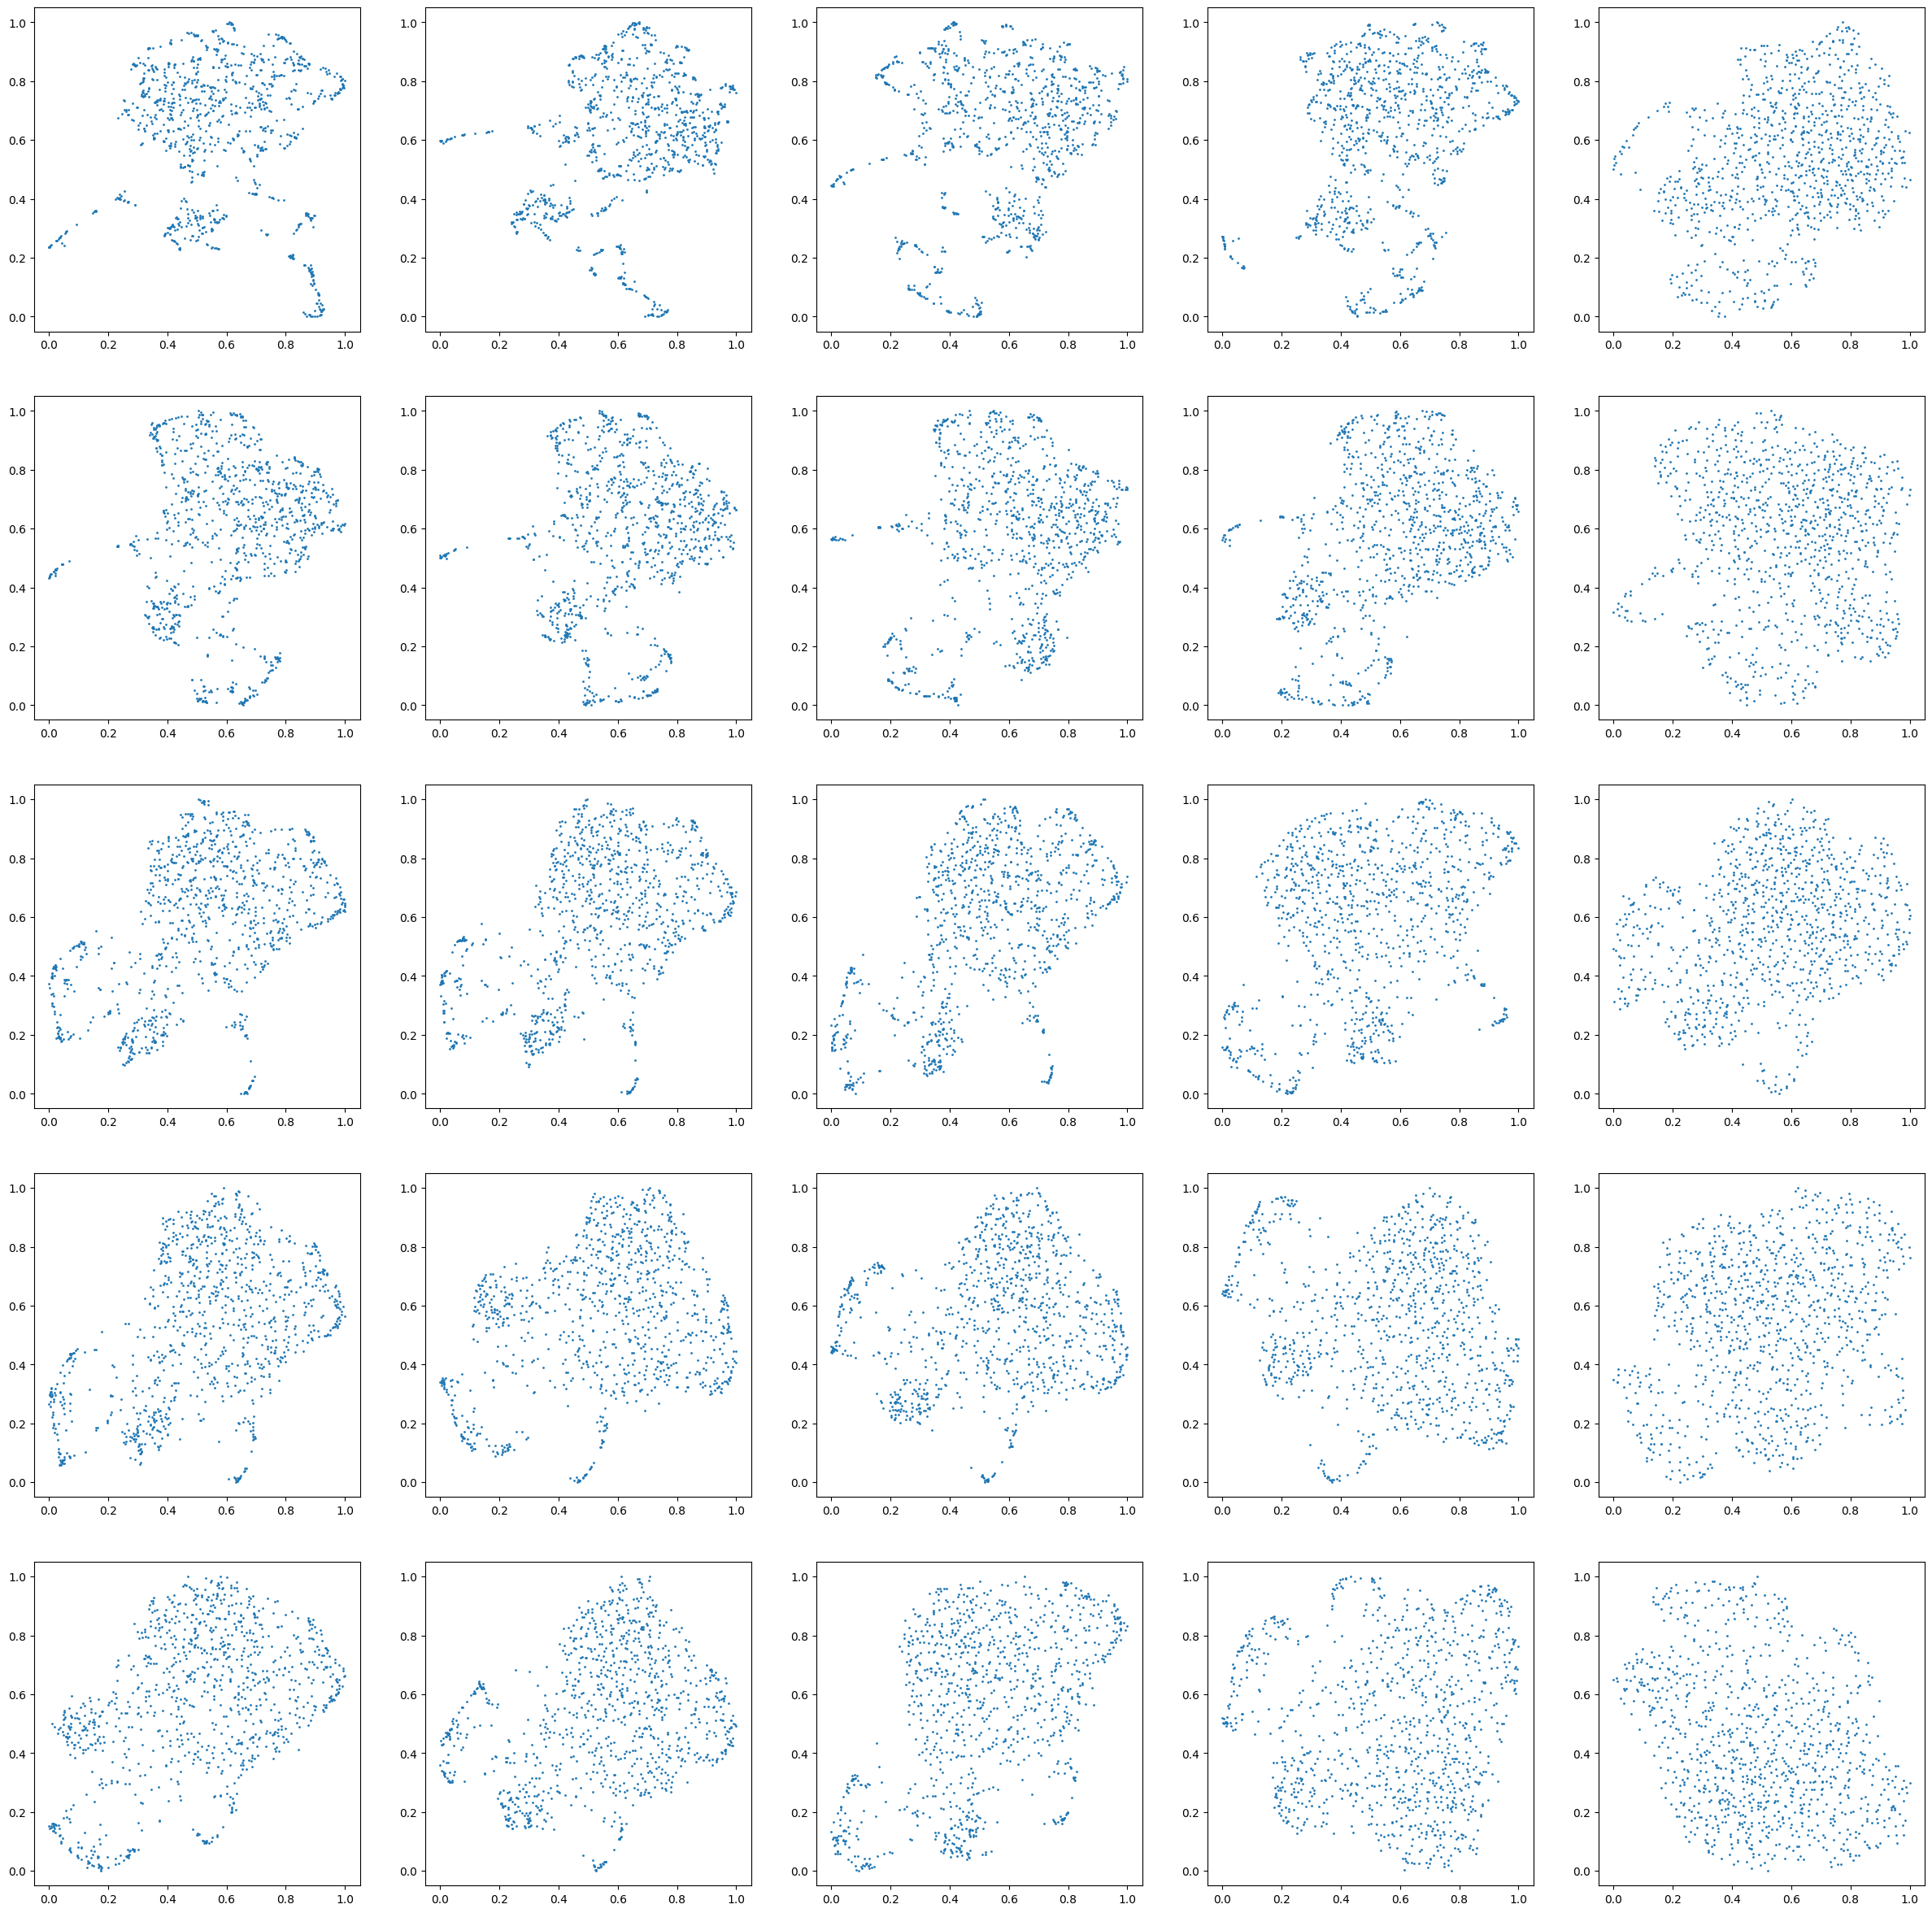

In [83]:
fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(umap_embeddings_mfccs[current_plot].T[0], 
                    umap_embeddings_mfccs[current_plot].T[1], 
                    s=1)
plt.show()

In [1]:

fig, ax = plt.subplots(nrows=len(neighbours), ncols=len(distances), figsize=(30, 30))

for i in range(len(neighbours)):
    for j in range(len(distances)):
        current_plot = i * len(distances) + j
        # Obtener los embebimientos y las etiquetas de clase para el gráfico actual
        embedding = umap_embeddings_mfccs[current_plot]
        class_labels = ylote_genero[current_plot]  # Supongamos que labels contiene las etiquetas de clase

        # Asignar colores diferentes a cada clase
        unique_labels = np.unique(class_labels)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))

        for k, label in enumerate(unique_labels):
            # Filtrar los puntos por clase y trazarlos con un color correspondiente
            points = embedding[class_labels == label]
            ax[i, j].scatter(points[:, 0], points[:, 1], s=1, color=colors(k))

plt.show()


NameError: name 'plt' is not defined

In [55]:
Xlote, waveforms, ylote_edades, paths = [], [], [], []

try:
    for Xlote, ylote_edades, ylote_genero, ylote_reg, waveforms, paths, *_ in dl_ent:
        try:
            for x in range(40):
                print(Xlote[x].shape)
                print(paths[x])
        except IndexError as e:
            print(f"IndexError in inner loop: {e}")
except RuntimeError as e:
    print(f"RuntimeError: {e}")
    # Opcionalmente, puedes imprimir la traza de la pila para obtener más detalles del error
    import traceback
    traceback.print_exc()


torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_2_audios/clean_0109_portuguese_nonscripted_1.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_17_audios/clean_1170_portuguese_scripted_0.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_10_audios/clean_0671_portuguese_scripted_0.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_4_audios/clean_0234_portuguese_nonscripted_2.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_76_audios/clean_5273_english_nonscripted_4.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_38_audios/clean_2632_hindi_nonscripted_1.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_27_audios/clean_1839_hindi_nonscripted_0.wav
torch.Size([30, 63])
/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_1_audios/clean_

Traceback (most recent call last):
  File "/tmp/ipykernel_4021483/2186817972.py", line 4, in <module>
    for Xlote, ylote_edades, ylote_genero, ylote_reg, waveforms, paths, *_ in dl_ent:
  File "/home/ar/miniconda3/envs/Aixa/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/home/ar/miniconda3/envs/Aixa/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/ar/miniconda3/envs/Aixa/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/ar/miniconda3/envs/Aixa/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/ar/miniconda3/envs/Aixa/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 142, in c

In [186]:
Xlote,waveforms, ylote_edades, paths = [], [], [], []
for Xlote, ylote_edades, ylote_genero, ylote_reg, waveforms, paths, *_ in dl_ent:
    print(Xlote.shape)
    # print(ylote_genero)
    # for x in range(40):
    #     print(Xlote[x].shape)
    #     print(paths[x])
    # break

torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([100, 30, 63])
torch.Size([

In [53]:
Xlote[39].shape

torch.Size([30, 63])

In [204]:
def plot_spectrogram(specgram, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    # ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [345]:
id=28

In [344]:
Xlote[id].shape

torch.Size([128, 32])

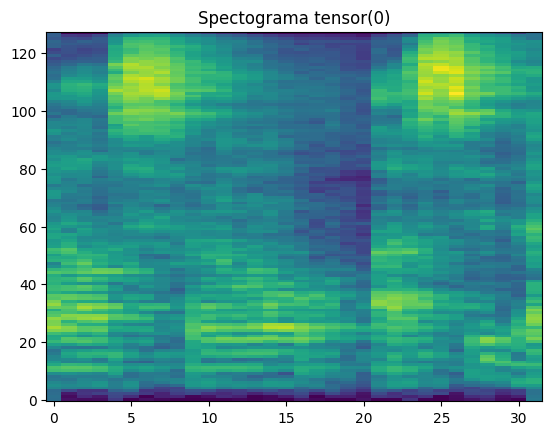

In [346]:
plot_spectrogram(Xlote[id], title="Spectograma "+ str(ylote_genero[id]))

In [347]:
ylote_reg[id]

tensor(36)

In [348]:
ylote_edades[id]

tensor(2)

In [349]:
paths[id]

'/home/ar/Data/AixaPL/Version1/PCIC23/downloadFiles/CCv2_part_17_audios/clean_1144_portuguese_nonscripted_5.wav'

In [350]:
ip.display.Audio(waveforms[id], rate=16000)

In [185]:
id2=39

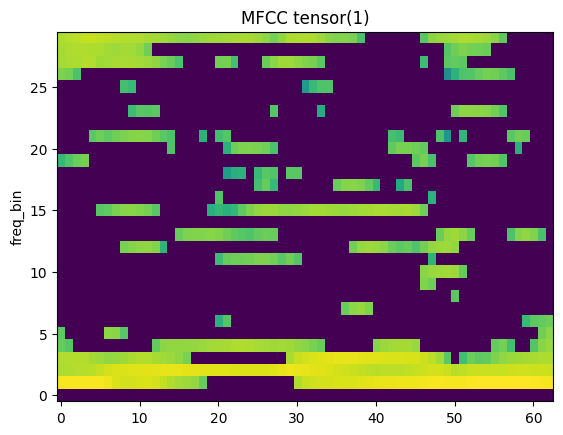

In [186]:
plot_spectrogram(Xlote[id2], title="MFCC "+ str(ylote_genero[id2]))

In [187]:
ylote_reg[id2]

tensor(49)

In [188]:
ip.display.Audio(waveforms[id2], rate=16000)

ENTRENAMIENTO

In [ ]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y
  aciertos = th.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score

In [ ]:
def paso_ent_Timit(modelo,
             fp_edades,
             fp_genero,
             fp_reg,
             metrica_edades,
             metrica_genero,
             metrica_edadN,
             opt,
             X,
             y_genero):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero

  y_hat_genero = modelo(X) # se propagan las entradas para obtener las predicciones

  y_pred_genero = torch.round(y_hat_genero)

  print(y_hat_genero)


  perdida_genero = F.binary_cross_entropy(y_hat_genero, y_genero.float()) #fp_edades
  # perdida_edad = F.cross_entropy(y_hat_edad, y_edad) #fp_genero
  # perdida_reg = F.mse_loss(y_hat_reg, y_reg.float()) #fp_reg

  w_genero = 0.01
  w_edad = 0.00
  w_reg = 0.00


  # Calcular la pérdida total como la suma ponderada de las pérdidas individuales
  perdida_total = perdida_genero.float()
  # perdida_total = w_genero * perdida_genero.float() + w_edad * perdida_edad.float() + w_reg * perdida_reg.float()
  perdida_total = perdida_total.float()

  # print(perdida_total.dtype)

  perdida_total.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo


  with th.no_grad():
    perdida_paso = perdida_total.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU

    metrica_genero_paso = metrica_genero(y_hat_genero, y_genero.float())
   
  return perdida_paso, metrica_genero_paso
  # return perdida_paso, metrica_edad_paso, metrica_genero_paso, metrica_reg_paso, weightedf1

In [ ]:
def paso_ent(modelo,
             fp_edades,
             fp_genero,
             fp_reg,
             metrica_edades,
             metrica_genero,
             metrica_edadN,
             opt,
             X,
             y_edad,
             y_genero,
             y_reg):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero

  y_hat_edad, y_hat_genero, y_hat_reg = modelo(X) # se propagan las entradas para obtener las predicciones

  # y_hat_genero = y_hat_genero.squeeze().float()
  # y_hat_reg = y_hat_reg.squeeze().float()


  # sacamos las probabilidades
  y_prob = F.softmax(y_hat_edad, 1)

  # sacamos las clases
  y_pred = torch.argmax(y_prob, 1).detach().cpu().numpy()

  # print(y_pred)
  # print(y_hat_edad)

  y_pred_genero = torch.round(y_hat_genero)

  # y_pred_detached = y_pred.detach()

  # perdida = F.cross_entropy(y_hat, y) # se calcula la pérdida
  # print('y_hat')
  # print(y_hat_edad.dtype)
  # print(y_hat_reg.dtype)
  # print(y_hat_genero.dtype)
  # print('y_')
  # print(y_genero.dtype)
  # print(y_edad.dtype)
  # print(y_reg.dtype)
  

  perdida_genero = F.binary_cross_entropy(y_hat_genero, y_genero.float()) #fp_edades
  perdida_edad = F.cross_entropy(y_hat_edad, y_edad) #fp_genero
  perdida_reg = F.mse_loss(y_hat_reg, y_reg.float()) #fp_reg

  # print('Perdidas')
  # print(perdida_genero.dtype)
  # print(perdida_edad.dtype)
  # print(perdida_reg.dtype)
  # Puedes ajustar los pesos según sea necesario
  w_genero =1.0
  w_edad =1.0
  w_reg =1.0

  # print('Pesos')
  # print(w_genero.dtype)
  # print(w_edad.dtype)
  # print(w_reg.dtype)

  # Calcular la pérdida total como la suma ponderada de las pérdidas individuales
  perdida_total = w_genero * perdida_genero.float() + w_edad * perdida_edad.float() + w_reg * perdida_reg.float()
  perdida_total = perdida_total.float()

  # print(perdida_total.dtype)

  perdida_total.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo


  with th.no_grad():
    perdida_paso = perdida_total.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    # metricas_paso = metrica(y_hat, y)

    metrica_genero_paso = metrica_genero(y_hat_genero, y_genero.float())
    metrica_edad_paso = metrica_edades(y_hat_edad, y_edad)
    metrica_reg_paso = metrica_edadN(y_hat_reg, y_reg) 

    weightedf1= f1_score(y_pred_genero.cpu(), y_pred, average='weighted')

  # return perdida_paso, metricas_paso
  return perdida_paso, metrica_edad_paso, metrica_genero_paso, metrica_reg_paso, weightedf1

In [ ]:
def entrena_Timit(modelo,
            fp_edades,
            fp_genero,
            fp_reg,
            metrica_edades,
            metrica_genero,
            metrica_edadN,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          # 'weightedF1_ent': np.zeros(n_epocas),
          # 'weightedF1_val': np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          # 'Accuracy_Edades_ent': np.zeros(n_epocas),
          # 'Accuracy_Edades_val': np.zeros(n_epocas),

          'Accuracy_Genero_ent': np.zeros(n_epocas),
          'Accuracy_Genero_val': np.zeros(n_epocas)}

          # 'MSE_Edad_ent': np.zeros(n_epocas),
          # 'MSE_Edad_val': np.zeros(n_epocas)}

  # tbwriter = SummaryWriter(tbdir)
  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)


  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for Xlote, ylote_genero, *_ in entdl:
      Xlote = Xlote.to(disp)
      # ylote_edades = ylote_edades.to(disp)
      ylote_genero = ylote_genero.to(disp)
      # ylote_reg = ylote_reg.to(disp)

      # perdida_paso, perdida_edad_paso, perdida_genero_paso, perdida_reg_paso, weightedf1
      perdida_paso, metrica_genero_paso = paso_ent_Timit(modelo,
                                            fp_edades,
                                            fp_genero,
                                            fp_reg,
                                            metrica_edades,
                                            metrica_genero,
                                            metrica_edadN,
                                            opt,
                                            Xlote,
                                            ylote_genero)

      hist['perdida_ent'][e] += perdida_paso
      # hist['weightedF1_ent'][e] += weightedf1
      # hist['Accuracy_Edades_ent'][e] += metrica_edad_paso
      hist['Accuracy_Genero_ent'][e] += metrica_genero_paso
      # hist['MSE_Edad_ent'][e] += metrica_reg_paso

    # bucle de validación
    modelo.eval()
    with th.no_grad():
      for Xlote, ylote_genero, *_  in valdl:
        Xlote = Xlote.to(disp)
        # ylote_edades = ylote_edades.to(disp)
        ylote_genero = ylote_genero.to(disp)
        # ylote_reg = ylote_reg.to(disp)

        y_hat_genero = modelo(Xlote)

        y_hat_genero = y_hat_genero.squeeze().float()
        # y_hat_reg = y_hat_reg.squeeze().float()

        # sacamos las probabilidades
        # y_prob = F.softmax(y_hat_edades, 1)

        # sacamos las clases
        # y_pred = torch.argmax(y_prob, 1)

        # weightedf1= f1_score(ylote_edades.cpu(), y_pred.cpu().numpy(), average='weighted')

        perdida_genero = F.binary_cross_entropy(y_hat_genero, ylote_genero.float()) #fp_edades
        # perdida_edad = F.cross_entropy(y_hat_edades, ylote_edades) #fp_genero
        # perdida_reg = F.mse_loss(y_hat_reg, ylote_reg) #fp_reg

        # Puedes ajustar los pesos según sea necesario
        w_genero = 0.01
        w_edad = 0.01
        w_reg = 0.01

        # Calcular la pérdida total como la suma ponderada de las pérdidas individuales
        perdida_total = perdida_genero.float()
        # perdida_total = w_genero * perdida_genero.float() + w_edad * perdida_edad.float() + w_reg * perdida_reg.float()

        metrica_genero_val = metrica_genero(y_hat_genero, ylote_genero.float())
        # metrica_edad_val = metrica_edades(y_hat_edades, ylote_edades)
        # metrica_reg_val = metrica_edadN(y_hat_reg, ylote_reg)

        hist['perdida_val'][e] += perdida_total
        # hist['weightedF1_val'][e] += weightedf1
        # hist['Accuracy_Edades_val'][e] += metrica_edad_val
        hist['Accuracy_Genero_val'][e] += metrica_genero_val
        # hist['MSE_Edad_val'][e] += metrica_reg_val

    # hist['weightedF1_ent'][e] /=  n_lotes_ent
    hist['perdida_ent'][e] /=  n_lotes_ent
    hist['perdida_ent'][e] =  hist['perdida_ent'][e]*100
    # hist['Accuracy_Edades_ent'][e] /= n_lotes_ent
    # hist['Accuracy_Edades_ent'][e] *= 100

    hist['Accuracy_Genero_ent'][e] /= n_lotes_ent
    hist['Accuracy_Genero_ent'][e] *= 100

    # hist['MSE_Edad_ent'][e] /= n_lotes_ent
    # hist['MSE_Edad_ent'][e] *= 100


    # hist['weightedF1_val'][e] /=  n_lotes_val
    hist['perdida_val'][e] /=  n_lotes_val
    hist['perdida_val'][e] =  hist['perdida_val'][e]*100

    # hist['Accuracy_Edades_val'][e] /= n_lotes_val
    # hist['Accuracy_Edades_val'][e] *= 100

    hist['Accuracy_Genero_val'][e] /= n_lotes_val
    hist['Accuracy_Genero_val'][e] *= 100

    # hist['MSE_Edad_val'][e] /= n_lotes_val
    # hist['MSE_Edad_val'][e] *= 100
    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    # registra_info_tboard(tbwriter, e, hist)

    
    wandb.log({"Validation_acc_genero": hist["Accuracy_Genero_val"][e],
                "Validation_loss_total": hist["perdida_val"][e] })
    
    wandb.log({"Train_acc_genero": hist["Accuracy_Genero_ent"][e], 
                "Train_loss_total": hist["perdida_ent"][e] })

    print(f'\nÉpoca {e}:\n '
          'ENTRENAMIENTO: \n'
          # f'weighted_F1(E) = {hist["weightedF1_ent"][e]:.3f},\n '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, \n'
          # f'Accuracy_Edades(E) = {hist["Accuracy_Edades_ent"][e]:.3f},\n '
          f'Accuracy_Genero(E) = {hist["Accuracy_Genero_ent"][e]:.3f},\n'
          # f'MSE_Edad(E) = {hist["MSE_Edad_ent"][e]:.3f},\n '
          'VALIDACIÓN: \n'
          # f'weighted_F1(V) = {hist["weightedF1_val"][e]:.3f},\n  '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f},\n  '
          # f'Accuracy_Edades(V) = {hist["Accuracy_Edades_val"][e]:.3f}\n '
          f'Accuracy_Genero(V) = {hist["Accuracy_Genero_val"][e]:.3f}\n '
          # f'MSE_Edad(V) = {hist["MSE_Edad_val"][e]:.3f}\n '
          '---------------------------------------------------------------------')

  return modelo, mejor_modelo, hist

In [ ]:
import copy

def entrena(modelo,
            fp_edades,
            fp_genero,
            fp_reg,
            metrica_edades,
            metrica_genero,
            metrica_edadN,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'weightedF1_ent': np.zeros(n_epocas),
          'weightedF1_val': np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          'Accuracy_Edades_ent': np.zeros(n_epocas),
          'Accuracy_Edades_val': np.zeros(n_epocas),

          'Accuracy_Genero_ent': np.zeros(n_epocas),
          'Accuracy_Genero_val': np.zeros(n_epocas),

          'MSE_Edad_ent': np.zeros(n_epocas),
          'MSE_Edad_val': np.zeros(n_epocas)}

  # tbwriter = SummaryWriter(tbdir)
  perdida_min = th.inf
  mejor_modelo = copy.deepcopy(modelo)


  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for Xlote, ylote_edades, ylote_genero, ylote_reg, *_ in entdl:
      Xlote = Xlote.to(disp)
      ylote_edades = ylote_edades.to(disp)
      ylote_genero = ylote_genero.to(disp)
      ylote_reg = ylote_reg.to(disp)

      # perdida_paso, perdida_edad_paso, perdida_genero_paso, perdida_reg_paso, weightedf1
      perdida_paso, metrica_edad_paso, metrica_genero_paso, metrica_reg_paso, weightedf1 = paso_ent(modelo,
                                            fp_edades,
                                            fp_genero,
                                            fp_reg,
                                            metrica_edades,
                                            metrica_genero,
                                            metrica_edadN,
                                            opt,
                                            Xlote,
                                            ylote_edades,
                                            ylote_genero,
                                            ylote_reg)

      hist['perdida_ent'][e] += perdida_paso
      hist['weightedF1_ent'][e] += weightedf1
      hist['Accuracy_Edades_ent'][e] += metrica_edad_paso
      hist['Accuracy_Genero_ent'][e] += metrica_genero_paso
      hist['MSE_Edad_ent'][e] += metrica_reg_paso

    # bucle de validación
    modelo.eval()
    with th.no_grad():
      for Xlote, ylote_edades, ylote_genero, ylote_reg, *_  in valdl:
        Xlote = Xlote.to(disp)
        ylote_edades = ylote_edades.to(disp)
        ylote_genero = ylote_genero.to(disp)
        ylote_reg = ylote_reg.to(disp)

        y_hat_edades, y_hat_genero, y_hat_reg = modelo(Xlote)

        y_hat_genero = y_hat_genero.squeeze().float()
        y_hat_reg = y_hat_reg.squeeze().float()

        # sacamos las probabilidades
        y_prob = F.softmax(y_hat_edades, 1)

        # sacamos las clases
        y_pred = torch.argmax(y_prob, 1)

        weightedf1= f1_score(ylote_edades.cpu(), y_pred.cpu().numpy(), average='weighted')

        perdida_genero = F.binary_cross_entropy(y_hat_genero, ylote_genero.float()) #fp_edades
        perdida_edad = F.cross_entropy(y_hat_edades, ylote_edades) #fp_genero
        perdida_reg = F.mse_loss(y_hat_reg, ylote_reg) #fp_reg

        # Puedes ajustar los pesos según sea necesario
        w_genero = 1.0
        w_edad = 1.0
        w_reg = 1.0

        # Calcular la pérdida total como la suma ponderada de las pérdidas individuales
        perdida_total = w_genero * perdida_genero.float() + w_edad * perdida_edad.float() + w_reg * perdida_reg.float()

        metrica_genero_val = metrica_genero(y_hat_genero, ylote_genero.float())
        metrica_edad_val = metrica_edades(y_hat_edades, ylote_edades)
        metrica_reg_val = metrica_edadN(y_hat_reg, ylote_reg)

        hist['perdida_val'][e] += perdida_total
        hist['weightedF1_val'][e] += weightedf1
        hist['Accuracy_Edades_val'][e] += metrica_edad_val
        hist['Accuracy_Genero_val'][e] += metrica_genero_val
        hist['MSE_Edad_val'][e] += metrica_reg_val

    hist['weightedF1_ent'][e] /=  n_lotes_ent
    hist['perdida_ent'][e] /=  n_lotes_ent
    hist['perdida_ent'][e] =  hist['perdida_ent'][e]*100
    hist['Accuracy_Edades_ent'][e] /= n_lotes_ent
    hist['Accuracy_Edades_ent'][e] *= 100

    hist['Accuracy_Genero_ent'][e] /= n_lotes_ent
    hist['Accuracy_Genero_ent'][e] *= 100

    hist['MSE_Edad_ent'][e] /= n_lotes_ent
    hist['MSE_Edad_ent'][e] *= 100


    hist['weightedF1_val'][e] /=  n_lotes_val
    hist['perdida_val'][e] /=  n_lotes_val
    hist['perdida_val'][e] =  hist['perdida_val'][e]*100

    hist['Accuracy_Edades_val'][e] /= n_lotes_val
    hist['Accuracy_Edades_val'][e] *= 100

    hist['Accuracy_Genero_val'][e] /= n_lotes_val
    hist['Accuracy_Genero_val'][e] *= 100

    hist['MSE_Edad_val'][e] /= n_lotes_val
    hist['MSE_Edad_val'][e] *= 100
    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    # registra_info_tboard(tbwriter, e, hist)

    print(f'\nÉpoca {e}:\n '
          'ENTRENAMIENTO: \n'
          f'weighted_F1(E) = {hist["weightedF1_ent"][e]:.3f},\n '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, \n'
          f'Accuracy_Edades(E) = {hist["Accuracy_Edades_ent"][e]:.3f},\n '
          f'Accuracy_Genero(E) = {hist["Accuracy_Genero_ent"][e]:.3f},\n'
          f'MSE_Edad(E) = {hist["MSE_Edad_ent"][e]:.3f},\n '
          'VALIDACIÓN: \n'
          f'weighted_F1(V) = {hist["weightedF1_val"][e]:.3f},\n  '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f},\n  '
          f'Accuracy_Edades(V) = {hist["Accuracy_Edades_val"][e]:.3f}\n '
          f'Accuracy_Genero(V) = {hist["Accuracy_Genero_val"][e]:.3f}\n '
          f'MSE_Edad(V) = {hist["MSE_Edad_val"][e]:.3f}\n '
          '---------------------------------------------------------------------')

  return modelo, mejor_modelo, hist

In [ ]:
import torch as th

MODELO

In [ ]:
DC = 'cuda:1' if th.cuda.is_available() else 'cpu'
LOGDIR = './logs/'
# N_EPOCAS = 100

In [ ]:
class FrotEnd(nn.Module):
    def __init__(self,dim_inicial, clases_age=NUM_CLASES_AGE, dropout=0.0, extract=False, onlyGender=False):
        super(FrotEnd, self).__init__()
        self.onlyGender= onlyGender

        self.age_classification = nn.Sequential(
            nn.Linear(dim_inicial,dim_inicial),
            nn.ReLU(),
            nn.BatchNorm1d(dim_inicial),
            nn.Linear(dim_inicial,clases_age),
            # nn.Softmax()
        )

        self.gender = nn.Sequential(
            nn.Linear(dim_inicial,dim_inicial),
            nn.ReLU(),
            nn.BatchNorm1d(dim_inicial),
            nn.Linear(dim_inicial,1),
            nn.Sigmoid()
        )

        self.age_regression = nn.Sequential(
            nn.Linear(dim_inicial,dim_inicial),
            nn.ReLU(),
            nn.BatchNorm1d(dim_inicial),
            nn.Linear(dim_inicial,1)
        )

    def forward(self, x):
        if self.onlyGender == False:
            age_classes = self.age_classification(x)
            age_classes = age_classes
        # age_classes = age_classes.float()
        
        gender = self.gender(x)
        gender = F.sigmoid(gender)
        gender = gender.squeeze().float()
        
        if self.onlyGender == False:
            age_regression = self.age_regression(x)
            age_regression = age_regression.squeeze().float()
        if self.onlyGender == False:
            return age_classes , gender , age_regression
        else:
            return gender

In [ ]:
class LSTMDvector(nn.Module):
    """LSTM-based d-vector."""
    def __init__(self, input_size, hidden_size=256 , embedding_size=256, num_layers=3,onlyGender=False):
        super(LSTMDvector, self).__init__()

        self.onlyGender= onlyGender
        self.num_layers=num_layers
        self.hidden_size= hidden_size
        self.device= DC
        
        self.lin = nn.Linear(input_size, input_size)
        self.norm = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=0.3, batch_first=True)
        self.lstm3 = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=0.3, batch_first=True)

        # Capa lineal para obtener el d-vector
        self.linear = nn.Linear(hidden_size, embedding_size)
        self.relu= nn.ReLU()

        self.frontEnd = FrotEnd(embedding_size,onlyGender=self.onlyGender)

    def forward(self, x):
        # Set initial hidden and cell states

        batch_size = x.size(0)
        x = x.unsqueeze(1)  # Add a batch dimension
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()

        # x= self.lin(x)
        # x= self.norm(x)

        lstm_out1, _ = self.lstm1(x, (h0, c0))
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out3, _ = self.lstm3(lstm_out2)

        # print(lstm_out1)
        # Tomar la última salida de la secuencia como d-vector
        d_vector = self.linear(lstm_out1[:, -1, :])

        # print(d_vector.shape)
        # print(d_vector)

        if self.onlyGender==False:
            class_edad, genero, edad_num = self.frontEnd(d_vector)

            return class_edad.float(), genero.float(), edad_num.float()
        else:
            genero = self.frontEnd(d_vector)

            return genero.float()

        # class_edad, genero, edad_num = self.frontEnd(d_vector)

        # return class_edad.float(), genero.float(), edad_num.float()


In [ ]:
test_layer = LSTMDvector(32000, onlyGender=True)
summary(test_layer, (40,32000), device='cpu',col_names=['input_size', 'output_size', 'num_params'])

In [ ]:
train_batch = next(iter(dl_ent))
train_batch[0].shape

In [ ]:
Red_xvect = LSTMDvector(32000, onlyGender=False)
gen = Red_xvect(train_batch[0])
# edad, gen, edNum = Red_xvect(train_batch[0])

In [ ]:
# print(gen)

In [ ]:
unique_classes = df_val['gender'].unique()
print(unique_classes)

In [ ]:
from torch.optim import Adam
red= LSTMDvector(32000, onlyGender=True)
red.to(DC)
perdida_edades = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
perdida_genero = nn.BCELoss(weight=None, reduction='mean')
perdida_edadN = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

metrica_edadN = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

TASA_AP=0.0001
TASA_AP2='0001'

opt = Adam(red.parameters(),
           lr=TASA_AP)

N_EPOCAS=15
DATASET='TIMIT'

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="LSTMDvector",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": TASA_AP,
    "architecture": "D-vector",
    "dataset": DATASET,
    "epochs": N_EPOCAS,
    "segundos":5,
    }
)


red_LSTMDvector, mejor_LSTMDvector, hist_LSTMDvector = entrena(red,
                                   perdida_edades,
                                   perdida_genero,
                                   perdida_edadN,
                                   exactitud,
                                   exactitud,
                                   metrica_edadN,
                                   opt,
                                   dl_ent,
                                   dl_val,
                                   DC,
                                   LOGDIR + '/red_LSTMDvector_multitaskAHORASI_'+DATASET+'_'+TASA_AP2+'_2seg.pt',
                                   n_epocas=N_EPOCAS,
                                   tbdir = LOGDIR)


In [ ]:
import matplotlib.pyplot as plt

# Supongamos que tienes un diccionario llamado hist que contiene tus métricas
# hist = ...

# Extrae los valores de Accuracy_Genero_ent y Accuracy_Genero_val
accuracy_genero_ent = hist_LSTMDvector['Accuracy_Genero_ent']
accuracy_genero_val = hist_LSTMDvector['Accuracy_Genero_val']

# Crea un gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_genero_ent) + 1), accuracy_genero_ent, label='Accuracy_Genero_ent')
plt.plot(range(1, len(accuracy_genero_val) + 1), accuracy_genero_val, label='Accuracy_Genero_val')

# Agrega etiquetas y título
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy_Genero_ent y Accuracy_Genero_val')
plt.legend()

# Guarda el gráfico en un archivo (puedes cambiar el formato según tus necesidades)
plt.savefig('./images/comparacion_accuracy_genero_DVector_'+TASA_AP2+'_'+DATASET+'_.png')



perdida_ent = hist_LSTMDvector['perdida_ent']
perdida_val = hist_LSTMDvector['perdida_val']

# Crea un gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(perdida_ent) + 1), perdida_ent, label='perdida_ent')
plt.plot(range(1, len(perdida_val) + 1), perdida_val, label='perdida_val')

# Agrega etiquetas y título
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Comparación de perdida_ent y perdida_val')
plt.legend()

# Guarda el gráfico en un archivo (puedes cambiar el formato según tus necesidades)
plt.savefig('./images/comparacion_perdida_DVector_'+TASA_AP2+'_'+DATASET+'_.png')


    
Accuracy_Edades_ent = hist_LSTMDvector['Accuracy_Edades_ent']
Accuracy_Edades_val = hist_LSTMDvector['Accuracy_Edades_val']

# Crea un gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(Accuracy_Edades_ent) + 1), Accuracy_Edades_ent, label='Accuracy_Edades_ent')
plt.plot(range(1, len(Accuracy_Edades_val) + 1), Accuracy_Edades_val, label='Accuracy_Edades_val')

# Agrega etiquetas y título
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy_Edades_ent y Accuracy_Edades_val')
plt.legend()

# Guarda el gráfico en un archivo (puedes cambiar el formato según tus necesidades)
plt.savefig('./images/DVector/comparacion_Accuracy_Edades_DVector_'+TASA_AP2+'_'+DATASET+'_.png')


MSE_Edad_ent = hist_LSTMDvector['MSE_Edad_ent']
MSE_Edad_val = hist_LSTMDvector['MSE_Edad_val']

# Crea un gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(MSE_Edad_ent) + 1), MSE_Edad_ent, label='MSE_Edad_ent')
plt.plot(range(1, len(MSE_Edad_val) + 1), MSE_Edad_val, label='MSE_Edad_val')

# Agrega etiquetas y título
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Comparación de MSE_Edad_ent y MSE_Edad_val')
plt.legend()

# Guarda el gráfico en un archivo (puedes cambiar el formato según tus necesidades)
plt.savefig('./images/DVector/comparacion_MSE_Edad_DVector_'+TASA_AP2+'_'+DATASET+'_.png')


weightedF1_ent = hist_LSTMDvector['weightedF1_ent']
weightedF1_val = hist_LSTMDvector['weightedF1_val']

# Crea un gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(weightedF1_ent) + 1), weightedF1_ent, label='weightedF1_ent')
plt.plot(range(1, len(weightedF1_val) + 1), weightedF1_val, label='weightedF1_val')

# Agrega etiquetas y título
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Comparación de weightedF1_ent y weightedF1_val')
plt.legend()

# Guarda el gráfico en un archivo (puedes cambiar el formato según tus necesidades)
plt.savefig('./images/DVector/comparacion_weightedF1_DVector_'+TASA_AP2+'_'+DATASET+'_.png')